# Pneumococcus modelling codes 

_Streptococcus pneumoniae_ (or 'pneumococcus') simulation codes used to explore possible transmission structures and dynamical properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pylab
import scipy.special as spec
import time

### Single serotype per person and exponential recovery time model

Start with a simple Markovian (exponentially-distributed in event time) recovery rate for each serotype. This first model will be based on the household-community split (as in [https://academic.oup.com/aje/article/166/2/228/98916]) with the following transmission probabilities for individuals (who we shall assume can only carry a single serotype at a time) within household $h$ (in which one event will occur per unit timestep) of age $a$, and the $i$-th serotype, over time interval $\delta t$

$${\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}-1,S^h_{a}\rightarrow S^h_{a}+1,t+\delta t) = \mu_{ai}{\cal I}^h_{ai}(t)\delta t \qquad$$
$$\qquad \qquad \qquad \qquad \qquad \quad {\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}+1,S^h_{a}\rightarrow S^h_{a}-1,t+\delta t)  = S^h_{a}(t)\Lambda^h_{ai}(t)\delta t = \left[ N^h_{a}-\sum_{\forall i'}{\cal I}^h_{ai'}(t)\right] \Lambda^h_{ai}(t)\delta t \quad$$
$${\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}-1,{\cal I}^h_{ai'}\rightarrow {\cal I}^h_{ai'}+1,t+\delta t) = f_{ii'}{\cal I}^h_{ai}(t)\Lambda^h_{ai'}(t)\delta t$$

where ${\cal I}^h_{ai}(t)$ denotes the number of infective individuals of age $a$ with serotype $i$ in the household, $S^h_{a}(t)$ denotes the number of susceptible individuals of age $a$ in the household, $f_{ii'}$ is the serotype competition matrix (where $\forall i\,\,f_{ii} = 0$) and $\mu_{ai}$ denotes the recovery rate of an individual of age $a$ from the $i$-th serotype. The force of infection $\Lambda^h_{ai}(t)$ is split into household $\lambda^h_{ai}(t)$ (with $N^h_a$ individuals of age $a$ living within it) and community $\lambda^{\rm com}_{ai}(t)$ parts in the following way

$$\Lambda^h_{ai}(t)=\lambda^h_{ai}(t)+\lambda^{h-{\rm com}}_{ai}(t)= \frac{1}{\sum_{\forall a}N^h_a}\sum_{\forall a'} \beta^{a'}_{ai}{\cal I}^h_{a'i}(t) + \frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\sum_{\forall a'}\sum_{\forall h' \neq h} \beta^{a'}_{ai}{\cal I}^{h'}_{a'i}(t)\,.$$

In the above expression, $\beta^{a'}_{ai}$ is the contact rate between individuals of ages $a$ and $a'$ for the $i$-th serotype, and $\alpha$ (<1) encodes the damping of community contact relative to the household. For computation speed, we can redefine the community term in the force of infection above for an individual in terms of the of the 'total community force of infection' $L_{ai}(t)$ for each age group and serotype like so

$$\lambda^{h-{\rm com}}_{ai}(t) = \frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\left[ L_{ai}(t) -\sum_{\forall a'}\beta^{a'}_{ai}{\cal I}^{h}_{a'i}(t) \right]\,,$$

where $L_{ai}(t)$ is defined as

$$L_{ai}(t) \equiv \sum_{\forall a'}\sum_{\forall h} \beta^{a'}_{ai}{\cal I}^{h}_{a'i}(t)\,,$$

such that 

$$\Lambda^h_{ai}(t)=\left[ \frac{1}{\sum_{\forall a}N^h_a} -\frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\right]\sum_{\forall a'} \beta^{a'}_{ai}{\cal I}^h_{a'i}(t) + \frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}L_{ai}(t)\,.$$

A stochastic simulation code which corresponds to this system is below. The key parameters are set first.

In [2]:
number_of_households = 100
number_of_serotypes = 100
demographic_household_fractions = [0.3,0.4,0.3] # [Children,Adults,Elderly]
alpha_damping = 0.1
number_of_realisations = 100
realisations_per_run = 10                       # Should be a factor of the number of realisations
time_at_beginning = 0.0                         # In units of years
time_at_end = 10.0                              # In units of years
do_nothing_timescale = 0.05                     # In units of years
simulation_with_replacement = True

These are followed by the contact rates, recovery rates and competition matrix.

In [3]:
children_to_children_contact_rates = np.ones(number_of_serotypes)
adult_to_adult_contact_rates = np.ones(number_of_serotypes)
elderly_to_elderly_contact_rates = np.ones(number_of_serotypes)
children_to_adult_contact_rates = np.ones(number_of_serotypes)
children_to_elderly_contact_rates = np.ones(number_of_serotypes)
adult_to_elderly_contact_rates = np.ones(number_of_serotypes)
competition_matrix = np.ones((number_of_serotypes,number_of_serotypes))-np.identity(number_of_serotypes) 
recovery_rates = np.ones(number_of_serotypes)

Finally, the initial conditions and plotting parameters.

In [4]:
# Parameters for the output plot stack
set_number_of_plot_columns = 10
set_number_of_plot_rows = 10
max_prevalence_plot = 0.1

# Draw the number of people within each household
household_people_numbers = np.random.randint(1,10,size=number_of_households)
total_number_of_people = np.sum(household_people_numbers)

# Draw the initial prevalences of each serotype
initial_prevalences = np.random.uniform(size=number_of_serotypes)
initial_prevalences = initial_prevalences/np.sum(initial_prevalences)

# Set the demographic numbers within each household
demographic_numbers = np.asarray([np.random.multinomial(hp,demographic_household_fractions) \
                                  for hp in household_people_numbers]).T
number_of_children_in_each_household = demographic_numbers[0]
number_of_adults_in_each_household = demographic_numbers[1]
number_of_elderly_in_each_household = demographic_numbers[2]

# Generate initial matrices of infectives - dimension 0 is the household ID, 
# dimension 1 is the serotype and dimension 2 is the realisation
household_children_infectives=np.tensordot(np.asarray([np.asarray(np.random.multinomial(n,initial_prevalences)) \
                                                       for n in number_of_children_in_each_household]),\
                                                       np.ones(realisations_per_run),axes=0) 
household_adult_infectives=np.tensordot(np.asarray([np.asarray(np.random.multinomial(n,initial_prevalences)) \
                                                    for n in number_of_adults_in_each_household]),\
                                                    np.ones(realisations_per_run),axes=0)
household_elderly_infectives=np.tensordot(np.asarray([np.asarray(np.random.multinomial(n,initial_prevalences)) \
                                                      for n in number_of_elderly_in_each_household]),\
                                                      np.ones(realisations_per_run),axes=0)

# Generate tensor of household numbers for each age group 
number_of_children_in_each_household_tensor = np.tensordot(number_of_children_in_each_household,\
                                              np.ones((number_of_serotypes,realisations_per_run)),axes=0)
number_of_adults_in_each_household_tensor = np.tensordot(number_of_adults_in_each_household,\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)
number_of_elderly_in_each_household_tensor = np.tensordot(number_of_elderly_in_each_household,\
                                             np.ones((number_of_serotypes,realisations_per_run)),axes=0)

Now we may run the simulation!

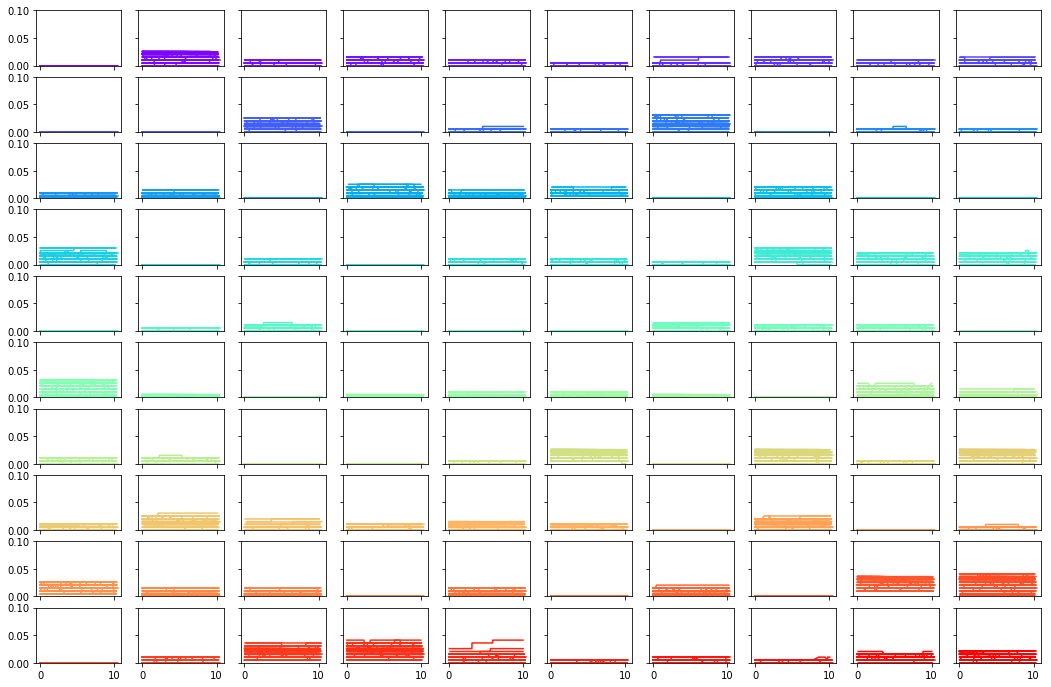

In [4]:
# Initialise subplots and colours of lines in each plot
fig, ax = plt.subplots(nrows=set_number_of_plot_rows,ncols=set_number_of_plot_columns)
colours = cm.rainbow(np.linspace(0,1,number_of_serotypes))

# Compute the number of runs required and initialise main loop
number_of_runs = int(number_of_realisations/realisations_per_run)
for n in range(0,number_of_runs):

    # Initialise storage for plot data
    plot_data = []
    plot_data_times = []
    
    # Initialise plot loop parameters
    rown = 0
    columnn = 0
    
    # Initialise time and run over realisations
    t = time_at_beginning*np.ones(realisations_per_run)
    terminated_realisations_per_run = np.ones(realisations_per_run)
    slowest_t = time_at_beginning
    while slowest_t < time_at_end:
    
        # Iterate forward in time 
        t = t + terminated_realisations_per_run*np.random.exponential(scale=do_nothing_timescale,\
                                                                      size=realisations_per_run)    
        # Set slowest time
        slowest_t = np.ndarray.min(t)
    
        # Event realisations at this timestep
        event_realisations = np.tensordot(np.random.uniform(size=(number_of_households,realisations_per_run)),\
                                          np.ones(number_of_serotypes),axes=0)
        event_realisations = np.swapaxes(event_realisations,1,2)
        
        # Total community forces of infection for each age group
        children_total_community_force_of_infection=np.sum((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_children_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_children_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_adult_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_adult_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_elderly_infectives),axis=0)
        adult_total_community_force_of_infection=np.sum((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             adult_to_adult_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_adult_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_adult_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_children_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             adult_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_elderly_infectives),axis=0)
        elderly_total_community_force_of_infection=np.sum((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             elderly_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_elderly_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_children_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             adult_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_adult_infectives),axis=0)
        
        # Recovery event rates for each age group
        children_recovery_event_rates = household_children_infectives*np.tensordot(np.ones(number_of_households),\
                                        np.tensordot(recovery_rates,np.ones(realisations_per_run),axes=0),axes=0)
        adult_recovery_event_rates = household_adult_infectives*np.tensordot(np.ones(number_of_households),\
                                     np.tensordot(recovery_rates,np.ones(realisations_per_run),axes=0),axes=0)
        elderly_recovery_event_rates = household_elderly_infectives*np.tensordot(np.ones(number_of_households),\
                                       np.tensordot(recovery_rates,np.ones(realisations_per_run),axes=0),axes=0)
        
        # Calculate the total number of infectives in each household 
        # to consistently compute the replacement event rates
        total_household_children_infectives = np.swapaxes(np.tensordot(np.sum(household_children_infectives,axis=1),\
                                                          np.ones(number_of_serotypes),axes=0),1,2)
        total_household_adult_infectives = np.swapaxes(np.tensordot(np.sum(household_adult_infectives,axis=1),\
                                                       np.ones(number_of_serotypes),axes=0),1,2)
        total_household_elderly_infectives = np.swapaxes(np.tensordot(np.sum(household_elderly_infectives,axis=1),\
                                                         np.ones(number_of_serotypes),axes=0),1,2)
        
        # Calculate the total number of suceptibles in each household 
        # to consistently compute the new carriage event rates
        total_household_children_susceptibles = number_of_children_in_each_household_tensor - \
                                                total_household_children_infectives
        total_household_adult_susceptibles = number_of_adults_in_each_household_tensor - \
                                             total_household_adult_infectives
        total_household_elderly_susceptibles = number_of_elderly_in_each_household_tensor - \
                                               total_household_elderly_infectives
        
        # New carriage event rates for each age group (also the forces of infection)
        children_foi = ((np.tensordot((household_people_numbers>1)/((household_people_numbers>1)*\
                         household_people_numbers.astype(float)),\
                         np.ones((number_of_serotypes,realisations_per_run)),axes=0)-\
                         np.tensordot(alpha_damping/(float(total_number_of_people)-\
                         household_people_numbers.astype(float)),\
                         np.ones((number_of_serotypes,realisations_per_run)),axes=0))*\
                         ((np.tensordot(np.tensordot(np.ones(number_of_households),\
                         children_to_children_contact_rates,axes=0),\
                         np.ones(realisations_per_run),axes=0)*\
                         household_children_infectives) + \
                         (np.tensordot(np.tensordot(np.ones(number_of_households),\
                         children_to_adult_contact_rates,axes=0),\
                         np.ones(realisations_per_run),axes=0)*\
                         household_adult_infectives) + \
                         (np.tensordot(np.tensordot(np.ones(number_of_households),\
                         children_to_elderly_contact_rates,axes=0),\
                         np.ones(realisations_per_run),axes=0)*\
                         household_elderly_infectives))) + \
                         (np.tensordot(alpha_damping/(float(total_number_of_people)-\
                         household_people_numbers.astype(float)),\
                         np.ones((number_of_serotypes,realisations_per_run)),axes=0)*\
                         (np.tensordot(np.ones(number_of_households),\
                         children_total_community_force_of_infection,axes=0)))   
        adult_foi = ((np.tensordot((household_people_numbers>1)/((household_people_numbers>1)*\
                      household_people_numbers.astype(float)),\
                      np.ones((number_of_serotypes,realisations_per_run)),axes=0)-\
                      np.tensordot(alpha_damping/(float(total_number_of_people)-\
                      household_people_numbers.astype(float)),\
                      np.ones((number_of_serotypes,realisations_per_run)),axes=0))*\
                      ((np.tensordot(np.tensordot(np.ones(number_of_households),\
                      adult_to_adult_contact_rates,axes=0),\
                      np.ones(realisations_per_run),axes=0)*\
                      household_adult_infectives) + \
                      (np.tensordot(np.tensordot(np.ones(number_of_households),\
                      children_to_adult_contact_rates,axes=0),\
                      np.ones(realisations_per_run),axes=0)*\
                      household_children_infectives) + \
                      (np.tensordot(np.tensordot(np.ones(number_of_households),\
                      adult_to_elderly_contact_rates,axes=0),\
                      np.ones(realisations_per_run),axes=0)*\
                      household_elderly_infectives))) + \
                      (np.tensordot(alpha_damping/(float(total_number_of_people)-\
                      household_people_numbers.astype(float)),\
                      np.ones((number_of_serotypes,realisations_per_run)),axes=0)*\
                      (np.tensordot(np.ones(number_of_households),\
                      adult_total_community_force_of_infection,axes=0)))
        elderly_foi = ((np.tensordot((household_people_numbers>1)/((household_people_numbers>1)*\
                        household_people_numbers.astype(float)),\
                        np.ones((number_of_serotypes,realisations_per_run)),axes=0)-\
                        np.tensordot(alpha_damping/(float(total_number_of_people)-\
                        household_people_numbers.astype(float)),\
                        np.ones((number_of_serotypes,realisations_per_run)),axes=0))*\
                        ((np.tensordot(np.tensordot(np.ones(number_of_households),\
                        elderly_to_elderly_contact_rates,axes=0),\
                        np.ones(realisations_per_run),axes=0)*\
                        household_elderly_infectives) + \
                        (np.tensordot(np.tensordot(np.ones(number_of_households),\
                        children_to_elderly_contact_rates,axes=0),\
                        np.ones(realisations_per_run),axes=0)*\
                        household_children_infectives) + \
                        (np.tensordot(np.tensordot(np.ones(number_of_households),\
                        adult_to_elderly_contact_rates,axes=0),\
                        np.ones(realisations_per_run),axes=0)*\
                        household_adult_infectives))) + \
                        (np.tensordot(alpha_damping/(float(total_number_of_people)-\
                        household_people_numbers.astype(float)),\
                        np.ones((number_of_serotypes,realisations_per_run)),axes=0)*\
                        (np.tensordot(np.ones(number_of_households),\
                        elderly_total_community_force_of_infection,axes=0)))
        children_new_carriage_event_rates = total_household_children_susceptibles*children_foi
        adult_new_carriage_event_rates = total_household_adult_susceptibles*adult_foi
        elderly_new_carriage_event_rates = total_household_elderly_susceptibles*elderly_foi
        
        # Evaluate the sum of rates of replacement events against each serotype for each age group and household
        children_replacement_against_event_rates_sum = (simulation_with_replacement==True)*\
                                                       household_children_infectives*\
                                                       np.swapaxes(np.tensordot(competition_matrix, \
                                                       children_foi,axes=([1],[1])),0,1)*\
                                                       (household_children_infectives>0)
        adult_replacement_against_event_rates_sum = (simulation_with_replacement==True)*\
                                                    household_adult_infectives*\
                                                    np.swapaxes(np.tensordot(competition_matrix, \
                                                    adult_foi,axes=([1],[1])),0,1)*\
                                                    (household_adult_infectives>0)
        elderly_replacement_against_event_rates_sum = (simulation_with_replacement==True)*\
                                                      household_elderly_infectives*\
                                                      np.swapaxes(np.tensordot(competition_matrix, \
                                                      elderly_foi,axes=([1],[1])),0,1)*\
                                                      (household_elderly_infectives>0)
        
        # Sum over possible events that can occur within each household
        sum_of_children_event_rates_in_each_household = np.tensordot(np.sum(((1.0/do_nothing_timescale) + \
                                                 children_recovery_event_rates + children_new_carriage_event_rates + \
                                                 children_replacement_against_event_rates_sum).astype(float),axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        sum_of_children_event_rates_in_each_household = np.swapaxes(sum_of_children_event_rates_in_each_household,1,2)
        sum_of_adult_event_rates_in_each_household = np.tensordot(np.sum(((1.0/do_nothing_timescale) + \
                                                 adult_recovery_event_rates + adult_new_carriage_event_rates + \
                                                 adult_replacement_against_event_rates_sum).astype(float),axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        sum_of_adult_event_rates_in_each_household = np.swapaxes(sum_of_adult_event_rates_in_each_household,1,2)
        sum_of_elderly_event_rates_in_each_household = np.tensordot(np.sum(((1.0/do_nothing_timescale) + \
                                                 elderly_recovery_event_rates + elderly_new_carriage_event_rates + \
                                                 elderly_replacement_against_event_rates_sum).astype(float),axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        sum_of_elderly_event_rates_in_each_household = np.swapaxes(sum_of_elderly_event_rates_in_each_household,1,2)

        # Make termination condition (because over time) a tensor for use in halting further transitions
        terminated_realisations_per_run_tensor = np.tensordot(np.ones((number_of_households,number_of_serotypes)),\
                                                 terminated_realisations_per_run,axes=0)
        
        # Sum over possible susceptible uptake, infective recovery and replacement transitions
        # possible for the household in order to compute the event probability mass
        children_rec_rate_sum = np.cumsum(children_recovery_event_rates,axis=1)
        children_rec_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                               children_rec_rate_sum[:,:-1,:],axis=1)
        children_rec_rate_sum_tot = np.tensordot(np.sum(children_recovery_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        children_rec_rate_sum_tot = np.swapaxes(children_rec_rate_sum_tot,1,2)
        children_new_carriage_rate_sum = np.cumsum(children_new_carriage_event_rates,axis=1)
        children_new_carriage_rate_sum_one_before=np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                              children_new_carriage_rate_sum[:,:-1,:],axis=1)
        children_new_carriage_rate_sum_tot = np.tensordot(np.sum(children_new_carriage_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        children_new_carriage_rate_sum_tot = np.swapaxes(children_new_carriage_rate_sum_tot,1,2)
        children_replace_rate_sum = np.cumsum(children_replacement_against_event_rates_sum,axis=1)
        children_replace_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                         children_replace_rate_sum[:,:-1,:],axis=1)
        adult_rec_rate_sum = np.cumsum(adult_recovery_event_rates,axis=1)
        adult_rec_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                            adult_rec_rate_sum[:,:-1,:],axis=1)
        adult_rec_rate_sum_tot = np.tensordot(np.sum(adult_recovery_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        adult_rec_rate_sum_tot = np.swapaxes(adult_rec_rate_sum_tot,1,2)
        adult_new_carriage_rate_sum = np.cumsum(adult_new_carriage_event_rates,axis=1)
        adult_new_carriage_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                           adult_new_carriage_rate_sum[:,:-1,:],axis=1)
        adult_new_carriage_rate_sum_tot = np.tensordot(np.sum(adult_new_carriage_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        adult_new_carriage_rate_sum_tot = np.swapaxes(adult_new_carriage_rate_sum_tot,1,2)
        adult_replace_rate_sum = np.cumsum(adult_replacement_against_event_rates_sum,axis=1)
        adult_replace_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                      adult_replace_rate_sum[:,:-1,:],axis=1)
        elderly_rec_rate_sum = np.cumsum(elderly_recovery_event_rates,axis=1)
        elderly_rec_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                              elderly_rec_rate_sum[:,:-1,:],axis=1)
        elderly_rec_rate_sum_tot = np.tensordot(np.sum(elderly_recovery_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        elderly_rec_rate_sum_tot = np.swapaxes(elderly_rec_rate_sum_tot,1,2)
        elderly_new_carriage_rate_sum = np.cumsum(elderly_new_carriage_event_rates,axis=1)
        elderly_new_carriage_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                             elderly_new_carriage_rate_sum[:,:-1,:],axis=1)
        elderly_new_carriage_rate_sum_tot = np.tensordot(np.sum(elderly_new_carriage_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        elderly_new_carriage_rate_sum_tot = np.swapaxes(elderly_new_carriage_rate_sum_tot,1,2)
        elderly_replace_rate_sum = np.cumsum(elderly_replacement_against_event_rates_sum,axis=1)
        elderly_replace_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                        elderly_replace_rate_sum[:,:-1,:],axis=1)
        
        # Evaluate the standard uptake-recovery transitions for these timesteps 
        household_children_infectives = household_children_infectives + \
                                        terminated_realisations_per_run_tensor*\
                                        (((children_new_carriage_rate_sum+\
                                        children_rec_rate_sum_tot)/\
                                        sum_of_children_event_rates_in_each_household > \
                                        event_realisations)*(event_realisations >= \
                                        (children_new_carriage_rate_sum_one_before+\
                                        children_rec_rate_sum_tot)/sum_of_children_event_rates_in_each_household))
        household_children_infectives = household_children_infectives - terminated_realisations_per_run_tensor*\
                                         ((event_realisations < children_rec_rate_sum/\
                                          sum_of_children_event_rates_in_each_household)*\
                                          (event_realisations >= children_rec_rate_sum_one_before/\
                                           sum_of_children_event_rates_in_each_household))  
        household_adult_infectives = household_adult_infectives + terminated_realisations_per_run_tensor*\
                                      (((adult_new_carriage_rate_sum+\
                                        adult_rec_rate_sum_tot)/\
                                        sum_of_adult_event_rates_in_each_household > \
                                        event_realisations)*(event_realisations >= \
                                        (adult_new_carriage_rate_sum_one_before+\
                                        adult_rec_rate_sum_tot)/sum_of_adult_event_rates_in_each_household))
        household_adult_infectives = household_adult_infectives - terminated_realisations_per_run_tensor*\
                                      ((event_realisations < adult_rec_rate_sum/\
                                       sum_of_adult_event_rates_in_each_household)*\
                                       (event_realisations >= adult_rec_rate_sum_one_before/\
                                       sum_of_adult_event_rates_in_each_household)) 
        household_elderly_infectives = household_elderly_infectives + terminated_realisations_per_run_tensor*\
                                        (((elderly_new_carriage_rate_sum+\
                                          elderly_rec_rate_sum_tot)/\
                                          sum_of_elderly_event_rates_in_each_household > \
                                          event_realisations)*(event_realisations >= \
                                         (elderly_new_carriage_rate_sum_one_before+\
                                          elderly_rec_rate_sum_tot)/sum_of_elderly_event_rates_in_each_household))
        household_elderly_infectives = household_elderly_infectives - terminated_realisations_per_run_tensor*\
                                          ((event_realisations < elderly_rec_rate_sum/\
                                          sum_of_elderly_event_rates_in_each_household)*\
                                          (event_realisations >= elderly_rec_rate_sum_one_before/\
                                          sum_of_elderly_event_rates_in_each_household))
        
        # Evaluate the serotype replacements for these timesteps - these are 0 if replacements aren't included
        household_children_infectives = household_children_infectives - terminated_realisations_per_run_tensor*\
                                        (((children_new_carriage_rate_sum_tot+\
                                        children_rec_rate_sum_tot+children_replace_rate_sum)/\
                                        sum_of_children_event_rates_in_each_household > \
                                        event_realisations)*(event_realisations >= \
                                        (children_new_carriage_rate_sum_tot+\
                                        children_rec_rate_sum_tot+children_replace_rate_sum_one_before)/\
                                        sum_of_children_event_rates_in_each_household))  
        household_adult_infectives = household_adult_infectives - terminated_realisations_per_run_tensor*\
                                     (((adult_new_carriage_rate_sum_tot+\
                                     adult_rec_rate_sum_tot+adult_replace_rate_sum)/\
                                     sum_of_adult_event_rates_in_each_household > \
                                     event_realisations)*(event_realisations >= (adult_new_carriage_rate_sum_tot+\
                                     adult_rec_rate_sum_tot+adult_replace_rate_sum_one_before)/\
                                     sum_of_adult_event_rates_in_each_household))        
        household_elderly_infectives = household_elderly_infectives - terminated_realisations_per_run_tensor*\
                                       (((elderly_new_carriage_rate_sum_tot+\
                                       elderly_rec_rate_sum_tot+elderly_replace_rate_sum)/\
                                       sum_of_elderly_event_rates_in_each_household > \
                                       event_realisations)*(event_realisations >= (elderly_new_carriage_rate_sum_tot+\
                                       elderly_rec_rate_sum_tot+elderly_replace_rate_sum_one_before)/\
                                       sum_of_elderly_event_rates_in_each_household))
        
        # Begin replacement event calculations if replacements are included
        if simulation_with_replacement == True:
        
            # Slow loop over serotypes to be replaced into (necessary to avoid tensor dimensionality problems)
            children_seroticker_event_rate_before = 0.0
            adult_seroticker_event_rate_before = 0.0
            elderly_seroticker_event_rate_before = 0.0
            for s in range(0,number_of_serotypes):
                children_seroticker_event_rate = (number_of_children_in_each_household_tensor>\
                                                  total_household_children_infectives)*\
                                                  household_children_infectives*\
                                                  np.swapaxes(np.tensordot(competition_matrix[:,0:s+1], \
                                                  children_foi[:,0:s+1,:],axes=([1],[1])),0,1)
                adult_seroticker_event_rate = (number_of_adults_in_each_household_tensor>\
                                               total_household_adult_infectives)*\
                                               household_adult_infectives*\
                                               np.swapaxes(np.tensordot(competition_matrix[:,0:s+1], \
                                               adult_foi[:,0:s+1,:],axes=([1],[1])),0,1)
                elderly_seroticker_event_rate = (number_of_elderly_in_each_household_tensor>\
                                                 total_household_elderly_infectives)*\
                                                 household_elderly_infectives*\
                                                 np.swapaxes(np.tensordot(competition_matrix[:,0:s+1], \
                                                 elderly_foi[:,0:s+1,:],axes=([1],[1])),0,1)
                household_children_infectives=household_children_infectives + terminated_realisations_per_run_tensor*\
                                                (((children_seroticker_event_rate+\
                                                children_new_carriage_rate_sum_tot+\
                                                children_rec_rate_sum_tot)/\
                                                sum_of_children_event_rates_in_each_household > \
                                                event_realisations)*(event_realisations >= \
                                           (children_seroticker_event_rate_before+children_new_carriage_rate_sum_tot+\
                                                children_rec_rate_sum_tot)/\
                                                sum_of_children_event_rates_in_each_household))
                household_adult_infectives = household_adult_infectives + terminated_realisations_per_run_tensor*\
                                                (((adult_seroticker_event_rate+\
                                                adult_new_carriage_rate_sum_tot+\
                                                adult_rec_rate_sum_tot)/\
                                                sum_of_adult_event_rates_in_each_household > \
                                                event_realisations)*(event_realisations >= \
                                                (adult_seroticker_event_rate_before+adult_new_carriage_rate_sum_tot+\
                                                adult_rec_rate_sum_tot)/\
                                                sum_of_adult_event_rates_in_each_household))
                household_elderly_infectives = household_elderly_infectives + terminated_realisations_per_run_tensor*\
                                                (((elderly_seroticker_event_rate+\
                                                elderly_new_carriage_rate_sum_tot+\
                                                elderly_rec_rate_sum_tot)/\
                                                sum_of_elderly_event_rates_in_each_household > \
                                                event_realisations)*(event_realisations >= \
                                             (elderly_seroticker_event_rate_before+elderly_new_carriage_rate_sum_tot+\
                                                elderly_rec_rate_sum_tot)/\
                                                sum_of_elderly_event_rates_in_each_household))   
                children_seroticker_event_rate_before = children_seroticker_event_rate
                adult_seroticker_event_rate_before = adult_seroticker_event_rate
                elderly_seroticker_event_rate_before = elderly_seroticker_event_rate

        # Compute the seroprevalences at these timesteps
        seroprevalence_realisations = np.sum(household_children_infectives + \
                                      household_adult_infectives + \
                                      household_elderly_infectives,axis=0).astype(float)/float(total_number_of_people)
        
        # Store plot data
        plot_data.append(seroprevalence_realisations)
        plot_data_times.append(t)
        
        # Trigger termination for the runs which have ended
        terminated_realisations_per_run = (t < time_at_end)

    # Plot the realisations of the seroprevalences
    for j,cn in zip(range(0,number_of_serotypes),colours):
        for i in range(0,realisations_per_run): 
            ax[rown,columnn].plot(np.asarray(plot_data_times)[:,i],np.asarray(plot_data)[:,j,i],c=cn)
            ax[rown,columnn].set_ylim([0.0,max_prevalence_plot])
            if rown != set_number_of_plot_rows-1:
                ax[rown,columnn].set_xticklabels([])
            if columnn != 0:
                ax[rown,columnn].set_yticklabels([])
        columnn += 1
        if columnn == set_number_of_plot_columns:
            columnn = 0
            rown += 1

# Change scale of plot
F = pylab.gcf()
DefaultSize = F.get_size_inches()
F.set_size_inches((DefaultSize[0]*3,DefaultSize[1]*3))
    
plt.show()

### A simple presence-absence version of the above model

For comparison with the model above, and to gain some mathematical insight, we shall make the approximation that for a given age group in a household, there can only be one serotype present at one time. Let us then define $p^h_{ai}(t)$ as the time-dependent probability of the $i$-th serotype being present in age group $a$ of household $h$, and $q^h_{a}(t)$ as the time-dependent probability of the absence of any serotype in age group $a$ of household $h$. Both of these probabilities combine to be normalised within each household according to 

$$\sum_{\forall a}\left[ q^h_a(t)+ \sum_{\forall i}p^h_{ai}(t)\right]=1\,.$$ 

Given the events defined in the above model, and the mean of the corresponding multinomial distribution for detecting presence against absence, we may then write the following master equations for the system

$N^h_ap^h_{ai}(t+\delta t)-N^h_ap^h_{ai}(t) = - \mu_{ai} N^h_ap^h_{ai}(t)\delta t +N^h_aq^h_{a}(t) \Lambda^h_{ai}(t) \delta t+ \sum_{\forall i'} \left[ f_{i'i}N^h_ap^h_{ai'}(t)\Lambda^h_{ai}(t) - f_{ii'}N^h_ap^h_{ai}(t)\Lambda^h_{ai'}(t)\right] \delta t$

$N^h_aq^h_{a}(t+\delta t)-N^h_aq^h_{a}(t) = \sum_{\forall i}\mu_{ai} N^h_ap^h_{ai}(t)\delta t - \sum_{\forall i} N^h_aq^h_{a}(t) \Lambda^h_{ai}(t)\delta t$

$\Lambda^h_{ai}(t) = \left[ \frac{1}{\sum_{\forall a}N^h_a} -\frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\right]\sum_{\forall a'} \beta^{a'}_{ai}N^h_{a'}p^h_{a'i}(t) + \frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\sum_{\forall a'}\sum_{\forall h} \beta^{a'}_{ai}N^h_{a'}p^{h}_{a'i}(t)\,.$

Where the probabilities above have been normalised by a weighting which accounts for the variability in numbers of individuals between households, but if $N^h_a=0$ then the system isn't evolved. By solving this system of ODEs and drawing multinomial samples from the resulting probabilities, we may compare this approximative model to the one above. This is simple to code up (but lengthy) and the output is...

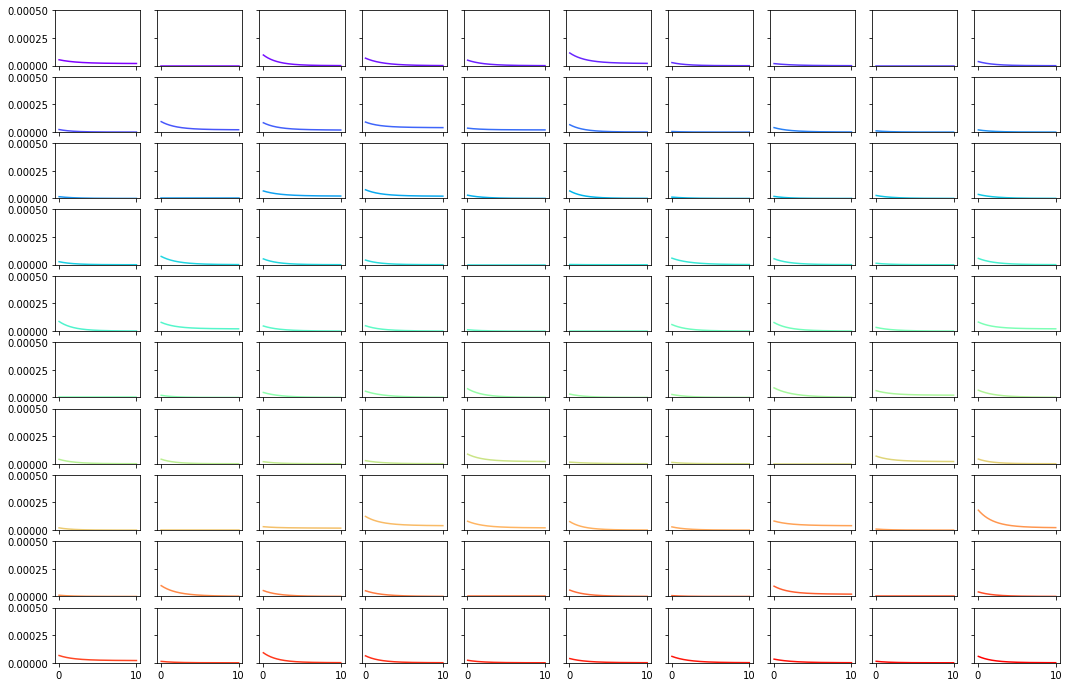

In [13]:
# Generate matrix of household numbers for each age group 
number_of_children_in_each_household_matrix = np.tensordot(number_of_children_in_each_household,\
                                              np.ones(number_of_serotypes),axes=0)
number_of_adults_in_each_household_matrix = np.tensordot(number_of_adults_in_each_household,\
                                            np.ones(number_of_serotypes),axes=0)
number_of_elderly_in_each_household_matrix = np.tensordot(number_of_elderly_in_each_household,\
                                             np.ones(number_of_serotypes),axes=0)

# Set initial prevalences from simulation above
prob_inf_children = household_children_infectives[:,:,0].astype(float)
prob_inf_adults = household_adult_infectives[:,:,0].astype(float)
prob_inf_elderly = household_elderly_infectives[:,:,0].astype(float)
prob_abs_children = np.sum(number_of_children_in_each_household_matrix.astype(float) - \
                           household_children_infectives[:,:,0],axis=1)
prob_abs_adults = np.sum(number_of_adults_in_each_household_matrix.astype(float) - \
                         household_adult_infectives[:,:,0],axis=1) 
prob_abs_elderly = np.sum(number_of_elderly_in_each_household_matrix.astype(float) - \
                          household_elderly_infectives[:,:,0],axis=1)
normalisation = np.sum(prob_inf_children+prob_inf_adults+prob_inf_elderly,axis=1) + \
                prob_abs_children + prob_abs_adults + prob_abs_elderly
prob_inf_children = prob_inf_children/np.tensordot(normalisation,np.ones(number_of_serotypes),axes=0)
prob_inf_adults = prob_inf_adults/np.tensordot(normalisation,np.ones(number_of_serotypes),axes=0)
prob_inf_elderly = prob_inf_elderly/np.tensordot(normalisation,np.ones(number_of_serotypes),axes=0)
prob_abs_children = prob_abs_children/normalisation
prob_abs_adults = prob_abs_adults/normalisation
prob_abs_elderly = prob_abs_elderly/normalisation

# Define system time evolution in a function
def evolve_system(system):
    [prob_inf_children,prob_inf_adults,prob_inf_elderly,prob_abs_children,prob_abs_adults,prob_abs_elderly] = system
    
    # Compute the normalisation factors in the forces of infection for all age groups
    norm_factor_term1 =  np.tensordot((1.0/(number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household)) - \
                         (alpha_damping/((np.sum(number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household)*np.ones(number_of_households))-\
                         (number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household))),np.ones(number_of_serotypes),axes=0)
    norm_factor_term2 =  np.tensordot((alpha_damping/((np.sum(number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household)*np.ones(number_of_households))-\
                         (number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household))),np.ones(number_of_serotypes),axes=0)
    
    # Compute the forces of infection for all of the age groups
    factor_children = ((np.tensordot(np.ones(number_of_households),\
                        children_to_children_contact_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*\
                        prob_inf_children) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_adult_contact_rates,axes=0)*\
                        number_of_adults_in_each_household_matrix*\
                        prob_inf_adults) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_elderly_contact_rates,axes=0)*\
                        number_of_elderly_in_each_household_matrix*\
                        prob_inf_elderly))
    factor_adults = ((np.tensordot(np.ones(number_of_households),\
                        adult_to_adult_contact_rates,axes=0)*\
                        number_of_adults_in_each_household_matrix*\
                        prob_inf_adults) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_adult_contact_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*\
                        prob_inf_children) + \
                       (np.tensordot(np.ones(number_of_households),\
                        adult_to_elderly_contact_rates,axes=0)*\
                        number_of_elderly_in_each_household_matrix*\
                        prob_inf_elderly))
    factor_elderly = ((np.tensordot(np.ones(number_of_households),\
                        elderly_to_elderly_contact_rates,axes=0)*\
                        number_of_elderly_in_each_household_matrix*\
                        prob_inf_elderly) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_elderly_contact_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*\
                        prob_inf_children) + \
                       (np.tensordot(np.ones(number_of_households),\
                        adult_to_elderly_contact_rates,axes=0)*\
                        number_of_adults_in_each_household_matrix*\
                        prob_inf_adults))
    foi_children = (norm_factor_term1*factor_children) + \
                   (norm_factor_term2*np.tensordot(np.ones(number_of_households),\
                    np.sum(factor_children,axis=0),axes=0))
    foi_adults = (norm_factor_term1*factor_adults) + \
                 (norm_factor_term2*np.tensordot(np.ones(number_of_households),\
                  np.sum(factor_adults,axis=0),axes=0))
    foi_elderly = (norm_factor_term1*factor_elderly) + \
                  (norm_factor_term2*np.tensordot(np.ones(number_of_households),\
                   np.sum(factor_elderly,axis=0),axes=0))
    
    # Use the forces of infection, recovery rates and competition matrices to evaluate time evolution in each state
    evol_inf_children = -(np.tensordot(np.ones(number_of_households),recovery_rates,axes=0)*\
                          number_of_children_in_each_household_matrix*prob_inf_children) + \
                         (number_of_children_in_each_household_matrix*\
                          np.tensordot(prob_abs_children,np.ones(number_of_serotypes),axes=0)*foi_children) + \
                         (np.tensordot(competition_matrix,\
                         (number_of_children_in_each_household_matrix*prob_inf_children),\
                          axes=([0],[1]))*foi_children) - \
                         (np.tensordot(competition_matrix,foi_children,axes=([1],[1]))*\
                         (number_of_children_in_each_household_matrix*prob_inf_children))
    evol_inf_adults = -(np.tensordot(np.ones(number_of_households),recovery_rates,axes=0)*\
                          number_of_adults_in_each_household_matrix*prob_inf_adults) + \
                         (number_of_adults_in_each_household_matrix*\
                          np.tensordot(prob_abs_adults,np.ones(number_of_serotypes),axes=0)*foi_adults) + \
                         (np.tensordot(competition_matrix,\
                         (number_of_adults_in_each_household_matrix*prob_inf_adults),\
                          axes=([0],[1]))*foi_adults) - \
                         (np.tensordot(competition_matrix,foi_adults,axes=([1],[1]))*\
                         (number_of_adults_in_each_household_matrix*prob_inf_adults))
    evol_inf_elderly = -(np.tensordot(np.ones(number_of_households),recovery_rates,axes=0)*\
                          number_of_elderly_in_each_household_matrix*prob_inf_elderly) + \
                         (number_of_elderly_in_each_household_matrix*\
                          np.tensordot(prob_abs_elderly,np.ones(number_of_serotypes),axes=0)*foi_elderly) + \
                         (np.tensordot(competition_matrix,\
                         (number_of_elderly_in_each_household_matrix*prob_inf_elderly),\
                          axes=([0],[1]))*foi_elderly) - \
                         (np.tensordot(competition_matrix,foi_elderly,axes=([1],[1]))*\
                         (number_of_elderly_in_each_household_matrix*prob_inf_elderly))
    evol_abs_children = np.sum((np.tensordot(np.ones(number_of_households),recovery_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*prob_inf_children) - \
                       (number_of_children_in_each_household_matrix*\
                        np.tensordot(prob_abs_children,np.ones(number_of_serotypes),axes=0)*foi_children),axis=1)
    evol_abs_adults = np.sum((np.tensordot(np.ones(number_of_households),recovery_rates,axes=0)*\
                      number_of_adults_in_each_household_matrix*prob_inf_adults) - \
                     (number_of_adults_in_each_household_matrix*\
                      np.tensordot(prob_abs_adults,np.ones(number_of_serotypes),axes=0)*foi_adults),axis=1)
    evol_abs_elderly = np.sum((np.tensordot(np.ones(number_of_households),recovery_rates,axes=0)*\
                       number_of_elderly_in_each_household_matrix*prob_inf_elderly) - \
                      (number_of_elderly_in_each_household_matrix*\
                       np.tensordot(prob_abs_elderly,np.ones(number_of_serotypes),axes=0)*foi_elderly),axis=1)
    
    # Correct for Np and Nq factors
    evol_inf_children[number_of_children_in_each_household_matrix>0] = \
    evol_inf_children[number_of_children_in_each_household_matrix>0].astype(float)/\
    number_of_children_in_each_household_matrix[number_of_children_in_each_household_matrix>0].astype(float)
    evol_inf_adults[number_of_adults_in_each_household_matrix>0] = \
    evol_inf_adults[number_of_adults_in_each_household_matrix>0].astype(float)/\
    number_of_adults_in_each_household_matrix[number_of_adults_in_each_household_matrix>0].astype(float)
    evol_inf_elderly[number_of_elderly_in_each_household_matrix>0] = \
    evol_inf_elderly[number_of_elderly_in_each_household_matrix>0].astype(float)/\
    number_of_elderly_in_each_household_matrix[number_of_elderly_in_each_household_matrix>0].astype(float)   
    evol_abs_children[number_of_children_in_each_household>0] = \
    evol_abs_children[number_of_children_in_each_household>0].astype(float)/\
    number_of_children_in_each_household[number_of_children_in_each_household>0].astype(float)
    evol_abs_adults[number_of_adults_in_each_household>0] = \
    evol_abs_adults[number_of_adults_in_each_household>0].astype(float)/\
    number_of_adults_in_each_household[number_of_adults_in_each_household>0].astype(float)
    evol_abs_elderly[number_of_elderly_in_each_household>0] = \
    evol_abs_elderly[number_of_elderly_in_each_household>0].astype(float)/\
    number_of_elderly_in_each_household[number_of_elderly_in_each_household>0].astype(float)
    
    # Output the evolution operators of each state
    return [evol_inf_children,evol_inf_adults,evol_inf_elderly,evol_abs_children,evol_abs_adults,evol_abs_elderly]

time = 0.0
system = [prob_inf_children,prob_inf_adults,prob_inf_elderly,\
          prob_abs_children,prob_abs_adults,prob_abs_elderly]
output_total_seroprevalences = []
output_times = []
while time < time_at_end:
    evolve_operator = evolve_system(system)
    for i in range(0,6): system[i] = system[i] + (do_nothing_timescale*evolve_operator[i])
    time = time + do_nothing_timescale
    output_total_seroprevalences.append(np.sum((number_of_children_in_each_household_matrix*system[0])+\
                                               (number_of_adults_in_each_household_matrix*system[1])+\
                                               (number_of_elderly_in_each_household_matrix*system[2]),axis=0)/\
                                        np.sum((number_of_children_in_each_household_matrix)+\
                                               (number_of_adults_in_each_household_matrix)+\
                                               (number_of_elderly_in_each_household_matrix),axis=0))
    output_times.append(time)

# Initialise subplots and colours of lines in each plot
fig, ax = plt.subplots(nrows=set_number_of_plot_rows,ncols=set_number_of_plot_columns)
colours = cm.rainbow(np.linspace(0,1,number_of_serotypes))    

# Initialise plot loop parameters
rown = 0
columnn = 0

# Parameters for the output plot stack
set_number_of_plot_columns = 10
set_number_of_plot_rows = 10
max_prevalence_plot = 0.0005

# Plot the realisations of the seroprevalences
for j,cn in zip(range(0,number_of_serotypes),colours):
    ax[rown,columnn].plot(output_times,np.asarray(output_total_seroprevalences).T[j],c=cn)
    ax[rown,columnn].set_ylim([0.0,max_prevalence_plot])
    if rown != set_number_of_plot_rows-1:
        ax[rown,columnn].set_xticklabels([])
    if columnn != 0:
        ax[rown,columnn].set_yticklabels([])
    columnn += 1
    if columnn == set_number_of_plot_columns:
        columnn = 0
        rown += 1

# Change scale of plot
F = pylab.gcf()
DefaultSize = F.get_size_inches()
F.set_size_inches((DefaultSize[0]*3,DefaultSize[1]*3))
    
plt.show()

Taking the continuous-time limit $\delta t \rightarrow 0$, the system above is essentially

$$N\dot{p} = {\cal F}(Np,Nq)$$
$$N\dot{q} = {\cal G}(Np,Nq)\,,$$

hence, the system Jacobian is

${\bf J}(N^h_ap^h_{ai},N^h_aq^h_{a}) \equiv \begin{bmatrix} \frac{1}{N^h_a}\frac{\partial {\cal F}^h_{ai}}{\partial p^h_{ai'}} & \frac{1}{N^h_a}\frac{\partial {\cal F}^h_{ai}}{\partial q^h_{a}} \\
\frac{1}{N^h_a}\frac{\partial {\cal G}^h_{a}}{\partial p^h_{ai'}} & \frac{1}{N^h_a}\frac{\partial {\cal G}^h_{a}}{\partial q^h_{a}} \end{bmatrix} $
$\qquad \qquad \qquad= \begin{bmatrix} - \mu_{ai} \delta_{ii'} +q^h_{a} \frac{\partial \Lambda^h_{ai}}{\partial p^{h}_{ai'}} + \sum_{\forall i''} \left( f_{i''i}\delta_{i''i'}\Lambda^h_{ai} + f_{i''i}p^h_{ai''}\frac{\partial \Lambda^h_{ai}}{\partial p^{h}_{ai'}} - f_{ii''}\delta_{ii'}\Lambda^h_{ai''} - f_{ii''}p^h_{ai}\frac{\partial \Lambda^h_{ai''}}{\partial p^{h}_{ai'}} \right) & \Lambda^h_{ai} \\
\mu_{ai'} - \frac{1}{\sum_{\forall a'}N^h_{a'}}\beta^{a}_{ai'}N^h_{a}q^h_{a} & - \sum_{\forall i}
\Lambda^h_{ai} \end{bmatrix}\,,$

where $\delta_{ii'}$ is the Kronecker delta and note we have used

$\frac{\partial \Lambda^h_{ai}}{\partial p^{h}_{ai'}} =  \left[ \frac{1}{\sum_{\forall a}N^h_a} -\frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\right]\sum_{\forall a'} \beta^{a'}_{ai}N^h_{a'}\delta_{ii'} + \frac{\alpha}{(\sum_{\forall h}\sum_{\forall a}N^h_a)-(\sum_{\forall a}N^h_a)}\sum_{\forall a'}\sum_{\forall h} \beta^{a'}_{ai}N^h_{a'}\delta_{ii'}$

$\Longrightarrow \frac{\partial \Lambda^h_{ai}}{\partial p^{h}_{ai}} = \frac{1}{\sum_{\forall a}N^h_a}\beta^{a}_{ai}N^h_{a}\,.$

TO DO: Fix $\beta$ and $\mu$ values, draw the probability $(1+\sum i)$-simplex $\{ p_i,q\}$ for each household from a symmetric Dirichlet distribution [https://en.wikipedia.org/wiki/Dirichlet_distribution] and draw elements of $f$ from some traceless random matrix group. Analyse the eigenvalue spectrum (with a Stieltjes transformation? - [https://arxiv.org/pdf/1712.07903.pdf]) of the system Jacobian random matrices and the Jacobian determinant values for system stability properties. Compare the analytic (if possible) results to runs of the ODE system. 

In [5]:
# Set random values for the infection probabilities in each serotype for Jacobian analysis
dirichlet_alpha = 1.0
q_val = 0.05
random_p_vals_and_q = np.append(np.random.dirichlet(dirichlet_alpha,size=number_of_serotypes),q_val)
random_p_vals_and_q = random_p_vals_and_q/np.sum(random_p_vals_and_q)

# Set values for calculating terms below
prob_inf_children = np.tensordot(np.ones(number_of_households),random_p_vals_and_q[:-1],axes=0)
prob_inf_adults = np.tensordot(np.ones(number_of_households),random_p_vals_and_q[:-1],axes=0)
prob_inf_elderly = np.tensordot(np.ones(number_of_households),random_p_vals_and_q[:-1],axes=0)
prob_abs_children = random_p_vals_and_q[-1]*np.ones((number_of_households,number_of_serotypes))
prob_abs_adults = random_p_vals_and_q[-1]*np.ones((number_of_households,number_of_serotypes))
prob_abs_elderly = random_p_vals_and_q[-1]*np.ones((number_of_households,number_of_serotypes))

# Compute the normalisation factors in the forces of infection for all age groups
norm_factor_term1 =  np.tensordot((1.0/(number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household)) - \
                         (alpha_damping/((np.sum(number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household)*np.ones(number_of_households))-\
                         (number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household))),np.ones(number_of_serotypes),axes=0)
norm_factor_term2 =  np.tensordot((alpha_damping/((np.sum(number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household)*np.ones(number_of_households))-\
                         (number_of_children_in_each_household + \
                          number_of_adults_in_each_household + \
                          number_of_elderly_in_each_household))),np.ones(number_of_serotypes),axes=0)

# Compute the forces of infection for all of the age groups
factor_children = ((np.tensordot(np.ones(number_of_households),\
                        children_to_children_contact_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*\
                        prob_inf_children) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_adult_contact_rates,axes=0)*\
                        number_of_adults_in_each_household_matrix*\
                        prob_inf_adults) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_elderly_contact_rates,axes=0)*\
                        number_of_elderly_in_each_household_matrix*\
                        prob_inf_elderly))
factor_adults = ((np.tensordot(np.ones(number_of_households),\
                        adult_to_adult_contact_rates,axes=0)*\
                        number_of_adults_in_each_household_matrix*\
                        prob_inf_adults) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_adult_contact_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*\
                        prob_inf_children) + \
                       (np.tensordot(np.ones(number_of_households),\
                        adult_to_elderly_contact_rates,axes=0)*\
                        number_of_elderly_in_each_household_matrix*\
                        prob_inf_elderly))
factor_elderly = ((np.tensordot(np.ones(number_of_households),\
                        elderly_to_elderly_contact_rates,axes=0)*\
                        number_of_elderly_in_each_household_matrix*\
                        prob_inf_elderly) + \
                       (np.tensordot(np.ones(number_of_households),\
                        children_to_elderly_contact_rates,axes=0)*\
                        number_of_children_in_each_household_matrix*\
                        prob_inf_children) + \
                       (np.tensordot(np.ones(number_of_households),\
                        adult_to_elderly_contact_rates,axes=0)*\
                        number_of_adults_in_each_household_matrix*\
                        prob_inf_adults))
foi_children = (norm_factor_term1*factor_children) + \
                   (norm_factor_term2*np.tensordot(np.ones(number_of_households),\
                    np.sum(factor_children,axis=0),axes=0))
foi_adults = (norm_factor_term1*factor_adults) + \
                 (norm_factor_term2*np.tensordot(np.ones(number_of_households),\
                  np.sum(factor_adults,axis=0),axes=0))
foi_elderly = (norm_factor_term1*factor_elderly) + \
                  (norm_factor_term2*np.tensordot(np.ones(number_of_households),\
                   np.sum(factor_elderly,axis=0),axes=0))

random_Jacobian = 
Jacobian_eigenvals = np.linalg.eig(random_Jacobian)

SyntaxError: invalid syntax (<ipython-input-5-0a990754d535>, line 79)